In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 30
%matplotlib inline  

In [9]:
import cv2

In [10]:
from infer_demo import Homographier,KeyPointModel

In [11]:
ckpt=r'/home/chiebotgpuhq/MyCode/python/pytorch/KP2D/data/models/kp2d/v4.ckpt'

In [12]:
image_list=[
    r'/home/chiebotgpuhq/MyCode/python/pytorch/KP2D/data/datasets/test/110kV东嘎变电站/110kV乃嘎II线0421隔离开关C相/20201101_07_00_01_1604185203386/110kV乃嘎II线0421隔离开关C相分合闸状态.jpg',
    r'/home/chiebotgpuhq/MyCode/python/pytorch/KP2D/data/datasets/test/110kV东嘎变电站/110kV乃嘎II线0421隔离开关C相/20200905_12_30_05_1599280213432/110kV乃嘎II线0421隔离开关C相分合闸状态.jpg',
]

In [13]:
def plt_show(img_path):
    img=mpimg.imread(img_path)
    plt.imshow(img)

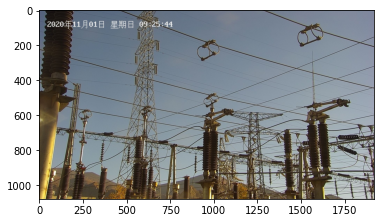

In [14]:
plt_show(image_list[0])

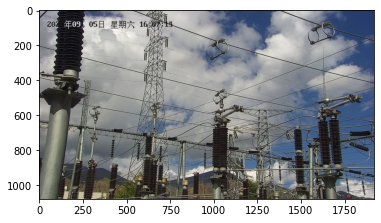

In [15]:
plt_show(image_list[1])

In [16]:
matcher=Homographier()

## 使用ORB特征

In [24]:
def get_orb(im1_path,im2_path):
    im1=cv2.imread(im1_path,cv2.IMREAD_COLOR)
    im2=cv2.imread(im2_path,cv2.IMREAD_COLOR)

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(1000)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    kp1_array= np.array([list(kp.pt) for kp in keypoints1])
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    kp2_array= np.array([list(kp.pt) for kp in keypoints2])
    return kp1_array, descriptors1,kp2_array,descriptors2

"""
def alignImages(im1_path, im2_path):


    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h


if __name__ == '__main__':
  
  # Read reference image
  refFilename = "form.jpg"
  print("Reading reference image : ", refFilename)
  imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

  # Read image to be aligned
  imFilename = "scanned-form.jpg"
  print("Reading image to align : ", imFilename);  
  im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
  
  print("Aligning images ...")
  # Registered image will be resotred in imReg. 
  # The estimated homography will be stored in h. 
  imReg, h = alignImages(im, imReference)
  
  # Write aligned image to disk. 
  outFilename = "aligned.jpg"
  print("Saving aligned image : ", outFilename); 
  cv2.imwrite(outFilename, imReg)

  # Print estimated homography
  print("Estimated homography : \n",  h)
"""

'\ndef alignImages(im1_path, im2_path):\n\n\n    # Match features.\n    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)\n    matches = matcher.match(descriptors1, descriptors2, None)\n\n    # Sort matches by score\n    matches.sort(key=lambda x: x.distance, reverse=False)\n\n    # Remove not so good matches\n    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)\n    matches = matches[:numGoodMatches]\n\n    # Draw top matches\n    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)\n    cv2.imwrite("matches.jpg", imMatches)\n\n    # Extract location of good matches\n    points1 = np.zeros((len(matches), 2), dtype=np.float32)\n    points2 = np.zeros((len(matches), 2), dtype=np.float32)\n\n    for i, match in enumerate(matches):\n    points1[i, :] = keypoints1[match.queryIdx].pt\n    points2[i, :] = keypoints2[match.trainIdx].pt\n\n    # Find homography\n    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)\n\n    

In [25]:
kp1_o,d1_o,kp2_o,d2_o=get_orb(*image_list)

In [26]:
H=matcher(kp1_o,d1_o,kp2_o,d2_o)

In [27]:
print(H)

[[-2.44887047e-01  8.58923033e-02  9.86341376e+01]
 [-9.17717074e-01  3.21992672e-01  3.69533560e+02]
 [-2.47825087e-03  8.68337970e-04  1.00000000e+00]]


In [ ]:
print(matcher())